In [1]:
import numpy as np
import seaborn as sns
import pandas as pd

### Контекст

Блокнот и код в нём навеян статьей на хабре о примении бутсрапа в предсказании статистики генеральной совокупности, в условиях наличия на руках только ограниченной выборки https://habr.com/ru/articles/829336/

**Коротко**: из выборки размера N извлекается большое число выборок с повторением размера N (бустрап-выборка) и N раз считается статистика по каждой бутстрап-выборке. Полученные статистики выстраиваются в персентили с учетом alpha (значимости). Реальное значение статистики по генеральной совокупности должно попасть в полученный коридор статистик по бутстрап-выборкам.

**Что внутри**: В функции get_bootstrap_ci реализован алгоритм расчета правой и левой границы коридора. Для проверки использованы два набора данных: синтетический на основе пуассоновского распределения и реальный из датасета о недвижимости.

### Набора данных 1
Искусственно созданный набор как сумма двух пуассоновских распределений

<Axes: ylabel='Count'>

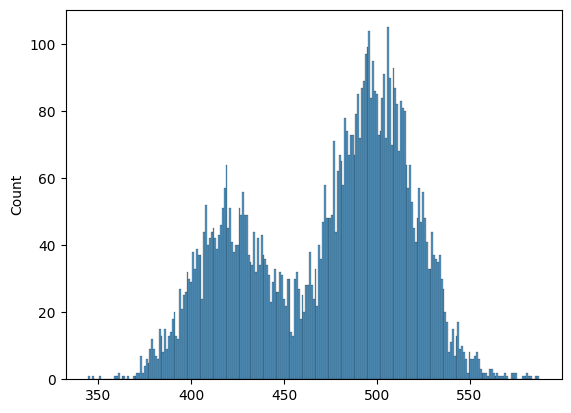

In [4]:
pois_distr1 = np.random.default_rng().poisson(lam=500., size=5000)
pois_distr2 = np.random.default_rng().poisson(lam=410., size=2500) + np.ones(2500, dtype=int)*10
pois_distr = np.concatenate((pois_distr1, pois_distr2), axis=0)
sns.histplot(pois_distr, discrete=True)

### Набор данных 2
Датасет с соревнования Kaggle - House Pricing https://www.kaggle.com/competitions/home-data-for-ml-course/data?select=test.csv

Объединил обучающую и тестовую выборку, т.к. работать буду со столбцом предиктором LotArea, а не таргетом. У распредления длинный хвост в сторону максимальных значений

In [5]:
train = pd.read_csv('/content/HousePricingTrain.csv')#, encoding='utf-16', index_col=[0])
test = pd.read_csv('/content/HousePricingTest.csv')#, encoding='utf-16', index_col=[0])
LotArea = pd.concat([train['LotArea'], test['LotArea']], ignore_index=True)

<Axes: xlabel='LotArea', ylabel='Count'>

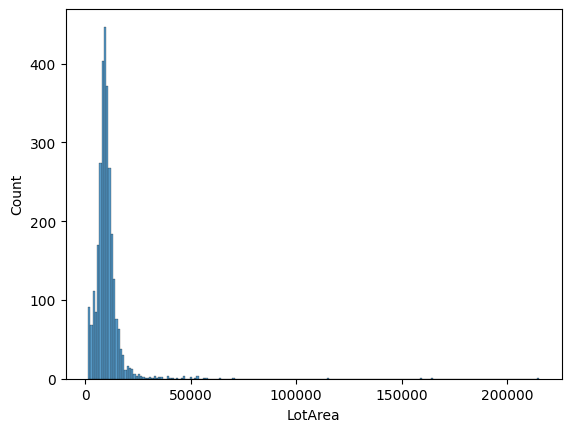

In [6]:
sns.histplot(LotArea, bins=200)

### Функция для подсчета статистики

In [7]:
def get_bootstrap_ci(
        general_X: np.ndarray,
        part_general: float,
        func, #применяемая статистика
        N: int = 10**3,
        alpha: float = 0.05):

    # Выборка из генеральной совокупности размера part_general
    sampleSize = np.int32(np.ceil(general_X.size * part_general))
    X = np.random.choice(a=general_X, size=sampleSize, replace=False)

    # Создание бустрап-выборок
    n = X.size
    bootstrap_samples = np.random.choice(a=X, size=(N, n), replace=True) # 1000 выборок разрмера n
    theta_hat_star = func(bootstrap_samples, axis=1)

    theta_hat = func(X)
    se_theta_hat = np.std(X, ddof=1) / np.sqrt(n) #стандартная ошибка по исходной выборке
    se_theta_hat_star = np.std(bootstrap_samples, axis=1, ddof=1) / np.sqrt(n) #стандартные ошибки по бустрап-выборкам

    theta_hat_star = (theta_hat_star - theta_hat) / se_theta_hat_star #центрированные стандартные ошибки

    left, right, median = np.quantile(theta_hat_star, (1 - alpha / 2, alpha / 2, 0.5))

    return (func(general_X),
            theta_hat,
            theta_hat - se_theta_hat * left,
            theta_hat - se_theta_hat * right,
            theta_hat - se_theta_hat * median
           )

### Применение к искусственным данным
Практически полное совпадение статистик. Это было ожидаемо - распредление довольно "скучковано" вокург его среднего

In [43]:
general_stat, sample_stat, left, right, median = get_bootstrap_ci(
                 general_X=pois_distr,
                 part_general=0.75,
                 func=np.mean,
                 N=1000,
                 alpha=0.01)
print(f'Вычисленная функция по генеральной совокупности: {general_stat} \nВычисленная функция по выборке: {sample_stat} \nЛевая и правая граница по бустрап-выборкам: {left}-{right} \nМедина функции по бутстрап-выборке {median}')

Вычисленная функция по генеральной совокупности: 473.06826666666666 
Вычисленная функция по выборке: 473.38826666666665 
Левая и правая граница по бустрап-выборкам: 471.9356614973077-474.8391939146583 
Медина функции по бутстрап-выборке 473.39912013215064


###Применение к реальным данным с большим хвостом

Возьму исходные данные

1. Очевидным образом при part_general -> 1 вычисленные статиститки почти совпадают;
2. А вот увеличение N может давать случайные результаты (как в лучшую, так и в худшую сторону)

In [26]:
general_stat, sample_stat, left, right, median = get_bootstrap_ci(
                 general_X=LotArea,
                 part_general=0.75,
                 func=np.mean,
                 N=1000,
                 alpha=0.01)
print(f'Вычисленная функция по генеральной совокупности: {general_stat} \nВычисленная функция по выборке: {sample_stat} \nЛевая и правая граница по бустрап-выборкам: {left}-{right} \nМедина функции по бутстрап-выборке {median}')

Вычисленная функция по генеральной совокупности: 10168.11408016444 
Вычисленная функция по выборке: 10272.053424657533 
Левая и правая граница по бустрап-выборкам: 9900.415546569788-10923.709048963086 
Медина функции по бутстрап-выборке 10293.575020112132


Откажусь от хвоста и сделаю данные более однозначно распредленными

<Axes: xlabel='LotArea', ylabel='Count'>

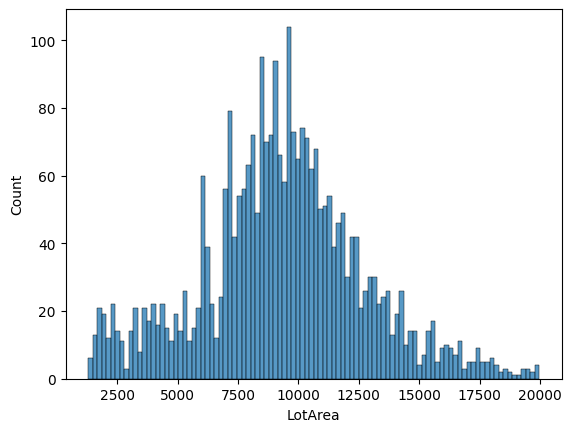

In [31]:
sns.histplot(LotArea[LotArea < 20000], bins=100)

При ограничении выборки и приведения распредления к более плотному, статистика стала ближе

In [32]:
general_stat, sample_stat, left, right, median = get_bootstrap_ci(
                 general_X=LotArea[LotArea < 20000],
                 part_general=0.75,
                 func=np.mean,
                 N=1000,
                 alpha=0.01)
print(f'Вычисленная функция по генеральной совокупности: {general_stat} \nВычисленная функция по выборке: {sample_stat} \nЛевая и правая граница по бустрап-выборкам: {left}-{right} \nМедина функции по бутстрап-выборке {median}')

Вычисленная функция по генеральной совокупности: 9327.6414427157 
Вычисленная функция по выборке: 9362.686468646865 
Левая и правая граница по бустрап-выборкам: 9181.693377990992-9547.974489618175 
Медина функции по бутстрап-выборке 9363.609449447631


### Попробую взять совсем незначительные выборки в 25% от исходных генеральных совокупностей

In [45]:
general_stat, sample_stat, left, right, median = get_bootstrap_ci(
                 general_X=LotArea,
                 part_general=0.25,
                 func=np.mean,
                 N=1000,
                 alpha=0.01)
print(f'Вычисленная функция по генеральной совокупности: {general_stat} \nВычисленная функция по выборке: {sample_stat} \nЛевая и правая граница по бустрап-выборкам: {left}-{right} \nМедина функции по бутстрап-выборке {median}')

Вычисленная функция по генеральной совокупности: 10168.11408016444 
Вычисленная функция по выборке: 10045.886301369863 
Левая и правая граница по бустрап-выборкам: 9469.578719129178-11068.810795309279 
Медина функции по бутстрап-выборке 10072.443705830203


In [46]:
general_stat, sample_stat, left, right, median = get_bootstrap_ci(
                 general_X=pois_distr,
                 part_general=0.25,
                 func=np.mean,
                 N=1000,
                 alpha=0.01)
print(f'Вычисленная функция по генеральной совокупности: {general_stat} \nВычисленная функция по выборке: {sample_stat} \nЛевая и правая граница по бустрап-выборкам: {left}-{right} \nМедина функции по бутстрап-выборке {median}')

Вычисленная функция по генеральной совокупности: 473.06826666666666 
Вычисленная функция по выборке: 473.51306666666665 
Левая и правая граница по бустрап-выборкам: 470.9652716595889-475.92913247891465 
Медина функции по бутстрап-выборке 473.51229832470597


### Наблюдения
а) Разные значения part_general и N по бутстрапу не приближают вычисленную статистику по выборке к значению этой статистики по генеральной совокупности (за редкими кейсами)

В общем то можно было ожидать - любое сэмплирование будет отсекать крайние (наибольшие и наименьшие) значения из ген.совокупности

б) Зато доверительные интервалы, вычисленные по alpha всегда точно определяют коридор значений для генеральной совокупности

Кажется именно в этом и кроется наибольшая практическая заничмость метода